In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import nbimporter   # pip install nbimporter
from fuzzification import get_fuzzy_sets_and_results, calculate_categorical_result




import sys
print('System version',sys.version)

ModuleNotFoundError: No module named 'fuzzification'

In [ ]:
# print('ACIT 4620')
# print('\nGroup-6')
# print('\nparticipate: Julie Hallen, Brage Ramberg, Alexander bazo, Daniel Bjordal, , Harith Elamin')

In [ ]:
print('Tools and Libraries:')
print('\n1- Python 3.')
print('\n2- scikit-fuzzy for fuzzy logic and fuzzy systems')
print('\n3- networkx for the creation, manipulation')
print('\n4- NumPy for numerical computations.')
print('\n5- pandas for data manipulation and analysis.')
print('\n6- requests for the process of sending and receiving data from websites.')
print('\n7- Matplotlib for plotting results.')
print('\n8-Keras for the convenience of mathematical calculations')


Tools and Libraries:

1- Python 3.

2- scikit-fuzzy for fuzzy logic and fuzzy systems

3- networkx for the creation, manipulation

4- NumPy for numerical computations.

5- pandas for data manipulation and analysis.

6- requests for the process of sending and receiving data from websites.

7- Matplotlib for plotting results.

8-Keras for the convenience of mathematical calculations


In [ ]:
# !pip3 freeze
# !pip3 install pandas scikit-fuzzy -U scikit-learn networkx numpy tensorflow keras matplotlib requests pandas seaborn

Project Proposal:

Datasets:

Employment history feature: 
https://www.kaggle.com/competitions/playground-series-s4e10/data?select=train.csv&fbclid=IwZXh0bgNhZW0CMTEAAR3m8MTqUNOmYlHeO4aSG3t27BQAZmFUhklp47HlrgQKs-a_jqKvER8MLxI_aem_wnn0vq8GNdEFy5I6HQg8XA

Credit score dataset feature: 
https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset?fbclid=IwZXh0bgNhZW0CMTEAAR3qB690tKMRmu3WPfOR3JX_uWnwWm5UZ8egilKtbPSOXpd80po5694E-Ew_aem_y6J4ieYEDtECW1CeA750dQ

In [ ]:
# Read the CSV file
data = pd.read_csv('../ACIT4620-24H-G6/dataset/loan_dataset.csv')

with open('dataset/filtered_df.pkl', 'rb') as f:
    df = pickle.load(f)

df

,Employment_Status,Annual_Income,Credit_Score,Outstanding_Debt,Loan_Amount_Requested,Loan_Type,Loan_Approval_Status
0,Employed,139901,743,19822,24535,Secured,1
1,Employed,21162,468,18321,8288,Unsecured,0
4,Employed,81753,752,8780,23360,Unsecured,1
8,Self-Employed,121626,803,13940,20239,Secured,0
10,Self-Employed,54670,772,22104,20000,Unsecured,1
...,...,...,...,...,...,...,...
51986,Self-Employed,105630,734,14841,26616,Unsecured,1
51989,Unemployed,118085,714,9803,30183,Secured,0
51990,Self-Employed,134581,756,15172,24717,Unsecured,1
51992,Unemployed,34019,572,19031,8383,Unsecured,0


In [ ]:
selected_columns = ['Employment_Status', 'Annual_Income', 'Credit_Score', 'Outstanding_Debt', 'Loan_Amount_Requested', 'Loan_Type', 'Loan_Approval_Status'] 

# no need for 'Loan_Purpose' 
# Loan_Purpose = ctrl.Antecedent(np.arange(0, 30, 0.1), 'Loan_Purpose') Do not need this, all are HOME

Employment_Status = ctrl.Antecedent(np.arange(18, 101, 1), 'Employment_Status')
Annual_Income = ctrl.Antecedent(np.arange(0, 500000, 1000), 'Annual_Income')
Credit_Score = ctrl.Antecedent(np.arange(1000, 50000, 500), 'Credit_Score')
Outstanding_Debt = ctrl.Antecedent(np.arange(0, 30, 0.1), 'Outstanding_Debt')
Loan_Amount_Requested = ctrl.Antecedent(np.arange(0, 1, 0.01), 'Loan_Amount_Requested')
Loan_Type = ctrl.Consequent(np.arange(0, 2, 1), 'Loan_Type')
Loan_Approval_Status = ctrl.Antecedent(np.arange(0, 1, 0.01), 'Loan_Approval_Status')


In [ ]:
selected_data = df[selected_columns]

X = df.iloc[:, :-1]  # All columns except the last one
y = df.iloc[:, -1]   # The last column

print(X.shape, y.shape)

# Display the split data
X.head(), y.head()


(20919, 6) (20919,)


(   Employment_Status  Annual_Income  Credit_Score  Outstanding_Debt  \
 0           Employed         139901           743             19822   
 1           Employed          21162           468             18321   
 4           Employed          81753           752              8780   
 8      Self-Employed         121626           803             13940   
 10     Self-Employed          54670           772             22104   
 
     Loan_Amount_Requested  Loan_Type  
 0                   24535    Secured  
 1                    8288  Unsecured  
 4                   23360  Unsecured  
 8                   20239    Secured  
 10                  20000  Unsecured  ,
 0     1
 1     0
 4     1
 8     0
 10    1
 Name: Loan_Approval_Status, dtype: int64)

In [ ]:
# Calculate averages manually for each Employment Status
employment_statuses = ["Self-Employed", "Unemployed", "Employed"]
averages = {}

for status in employment_statuses:
    subset = df[df["Employment_Status"] == status]
    averages[status] = {
        "Annual_Income": subset["Annual_Income"].mean(),
        "Credit_Score": subset["Credit_Score"].mean(),
        "Outstanding_Debt": subset["Outstanding_Debt"].mean(),
        "Loan_Amount_Requested": subset["Loan_Amount_Requested"].mean(),
        "Loan_Approval_Status": subset["Loan_Approval_Status"].mean(),
    }

# Print the results
for status, metrics in averages.items():
    print(f"Average metrics for {status}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.2f}")
    print()

Average metrics for Self-Employed:
  Annual_Income: 84185.91
  Credit_Score: 680.25
  Outstanding_Debt: 14839.15
  Loan_Amount_Requested: 21226.48
  Loan_Approval_Status: 0.65

Average metrics for Unemployed:
  Annual_Income: 83925.89
  Credit_Score: 678.40
  Outstanding_Debt: 15028.39
  Loan_Amount_Requested: 21135.45
  Loan_Approval_Status: 0.63

Average metrics for Employed:
  Annual_Income: 83358.82
  Credit_Score: 676.35
  Outstanding_Debt: 15068.12
  Loan_Amount_Requested: 21057.32
  Loan_Approval_Status: 0.64



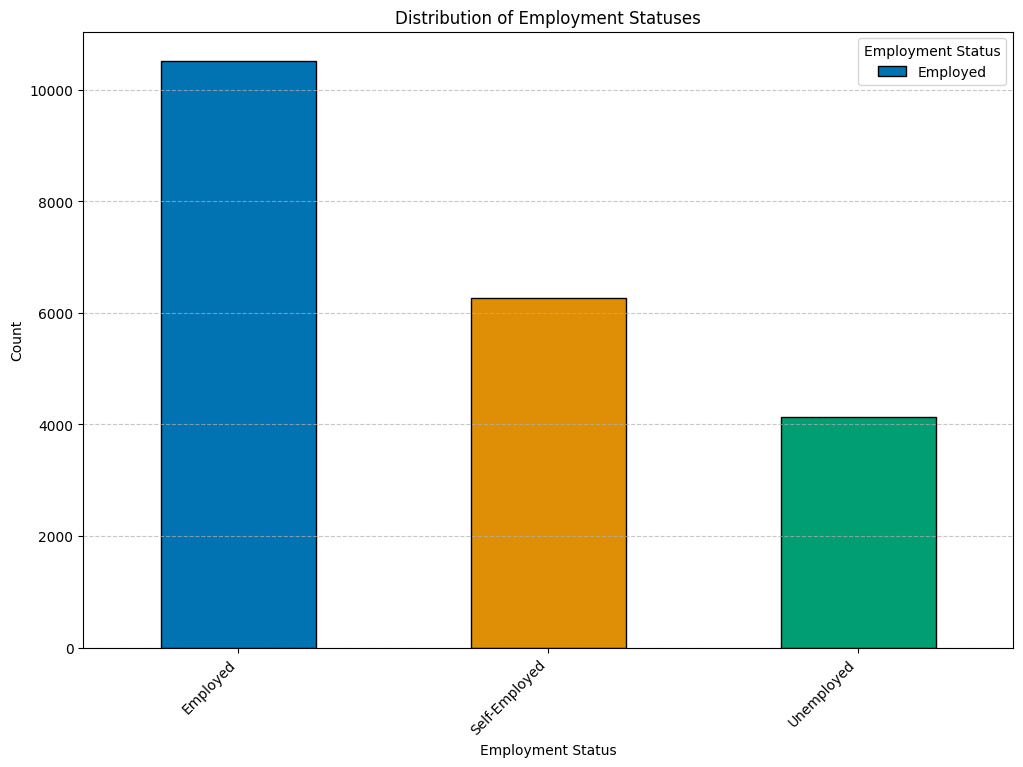

/var/folders/xq/6bpk1xjx63zdsznjsn67t60r0000gn/T/ipykernel_41242/345906494.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Employment_Status", y="Annual_Income", data=df, palette=colors)


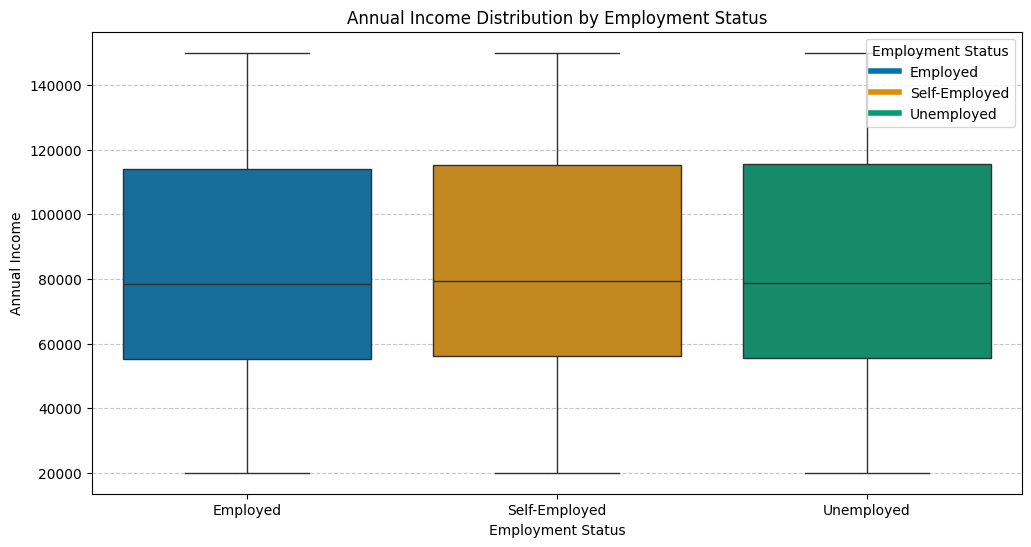

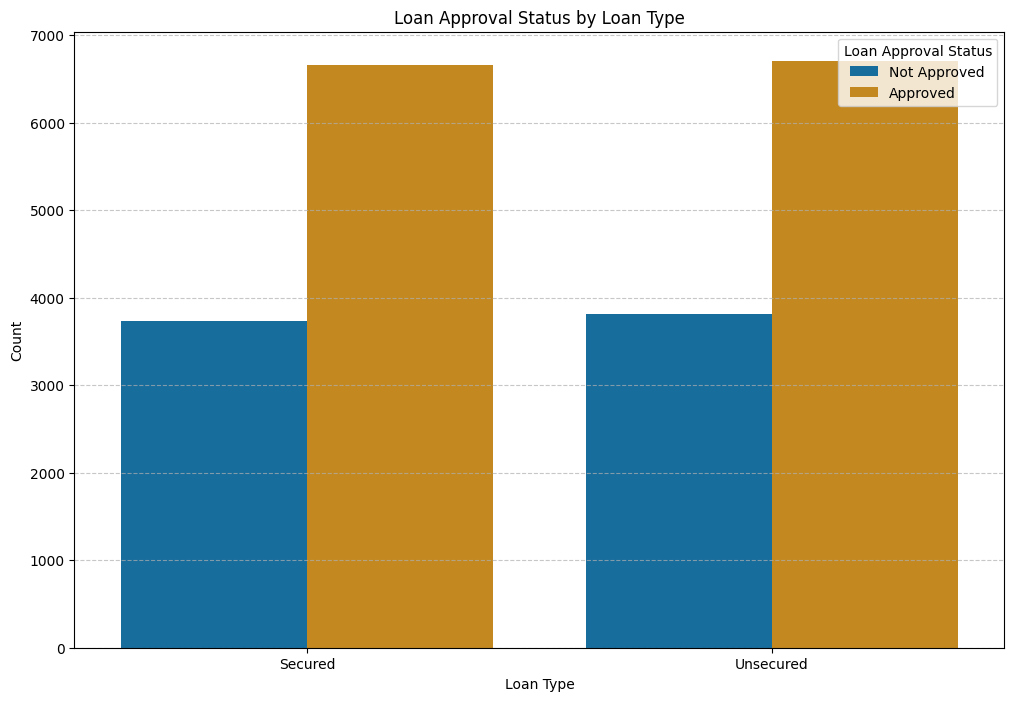

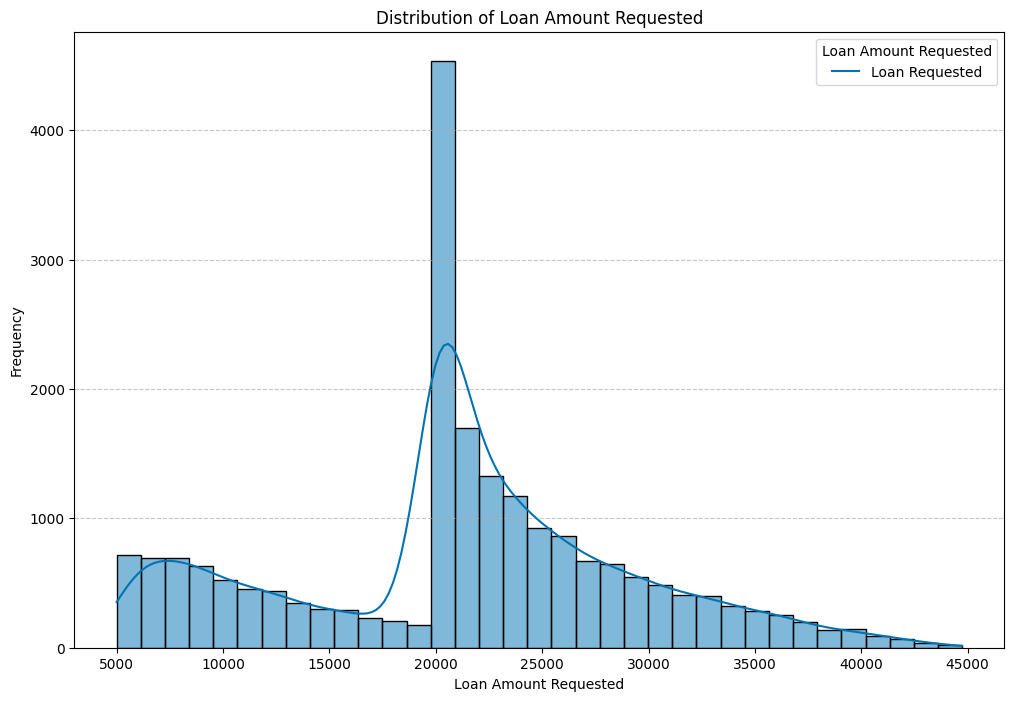

In [ ]:
# Set seaborn colorblind palette
sns.set_palette("colorblind")

# Plot 1: Distribution of Employment Statuses with rotated x labels using colorblind palette for each status
plt.figure(figsize=(12, 8))
colors = sns.color_palette("colorblind", n_colors=len(df["Employment_Status"].unique()))
ax = df["Employment_Status"].value_counts().plot(kind="bar", color=colors, edgecolor="black")
plt.title("Distribution of Employment Statuses")
plt.xlabel("Employment Status")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')  # Rotate x labels
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Employment Status", labels=df["Employment_Status"].unique())
plt.show()

# Plot 2: Boxplot for Annual Income by Employment Status with manually set colors and correct legend
plt.figure(figsize=(12, 6))

# Manually set the color for each Employment Status (3 colors)
colors = sns.color_palette("colorblind", n_colors=3)

# Create the boxplot without the legend
ax = sns.boxplot(x="Employment_Status", y="Annual_Income", data=df, palette=colors)

# Set title and labels
plt.title("Annual Income Distribution by Employment Status")
plt.xlabel("Employment Status")
plt.ylabel("Annual Income")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Manually creating the legend to match colors
handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(3)]
plt.legend(handles, df["Employment_Status"].unique(), title="Employment Status", loc="upper right")

# Show the plot
plt.show()

# Plot 3: Count plot for Loan Approval Status by Loan Type
plt.figure(figsize=(12, 8))
ax = sns.countplot(x="Loan_Type", hue="Loan_Approval_Status", data=df, palette="colorblind")
plt.title("Loan Approval Status by Loan Type")
plt.xlabel("Loan Type")
plt.ylabel("Count")
plt.legend(title="Loan Approval Status", loc="upper right", labels=["Not Approved", "Approved"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot 4: Distribution of Loan Amount Requested
plt.figure(figsize=(12, 8))
sns.histplot(df["Loan_Amount_Requested"], bins=35, kde=True, color=sns.color_palette("colorblind")[0], edgecolor="black")
plt.title("Distribution of Loan Amount Requested")
plt.xlabel("Loan Amount Requested")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Loan Amount Requested", labels=["Loan Requested"])
plt.show()

In [ ]:
X

,Employment_Status,Annual_Income,Credit_Score,Outstanding_Debt,Loan_Amount_Requested,Loan_Type
0,Employed,139901,743,19822,24535,Secured
1,Employed,21162,468,18321,8288,Unsecured
4,Employed,81753,752,8780,23360,Unsecured
8,Self-Employed,121626,803,13940,20239,Secured
10,Self-Employed,54670,772,22104,20000,Unsecured
...,...,...,...,...,...,...
51986,Self-Employed,105630,734,14841,26616,Unsecured
51989,Unemployed,118085,714,9803,30183,Secured
51990,Self-Employed,134581,756,15172,24717,Unsecured
51992,Unemployed,34019,572,19031,8383,Unsecured


In [ ]:
# Get all fuzzy sets and results
annual_income, loan_amount_requested, outstanding_debt, result = get_fuzzy_sets_and_results(df)

def print_fuzzy_graphs(*fuzzy_sets):
    """
    Function to view the fuzzy membership functions for multiple fuzzy sets.
    
    Parameters:
    - *fuzzy_sets: Variable number of fuzzy sets to be viewed.
    """
    for fuzzy_set in fuzzy_sets:
        fuzzy_set.view()  # View the fuzzy membership functions for each fuzzy set

# Call the function with all fuzzy sets
# print_fuzzy_graphs(annual_income, loan_amount_requested, outstanding_debt, result)

In [ ]:
# Apply the function, passing the fuzzy sets as arguments
X['Fuzzy_Category_Result'] = X.apply(calculate_categorical_result, axis=1, 
                                     annual_income=annual_income, 
                                     outstanding_debt=outstanding_debt)

print(X.shape, y.shape)




(20919, 7) (20919,)


Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.60      0.57      7554
           1       0.76      0.72      0.74     13365

    accuracy                           0.68     20919
   macro avg       0.65      0.66      0.66     20919
weighted avg       0.68      0.68      0.68     20919



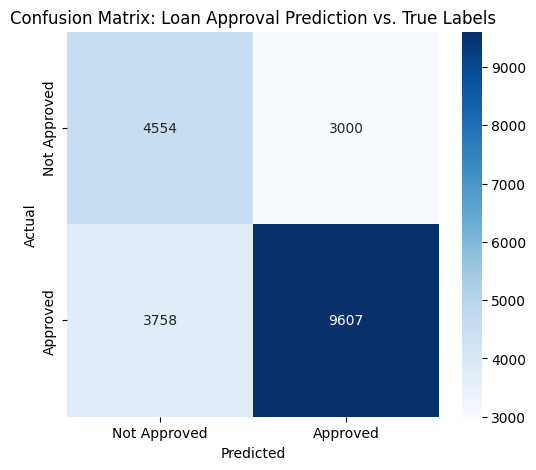

Accuracy: 67.69%


In [ ]:
def calculate_approval_status(fuzzy_category):
    """
    Function to determine loan approval status based on fuzzy categories and true labels.

    Parameters:
    - fuzzy_category: The fuzzy result category (low, medium, high).
    
    Returns:
    - approval_status: The loan approval status as 0 or 1.
    """
    approval_status = []
    
    # Loop through fuzzy categories and convert them to numeric values
    for category in fuzzy_category:
        if category in ['medium', 'high']:
            approval_status.append(1)   # Approved
        else:
            approval_status.append(0)   # Not approved
    
    return approval_status


def compare_results(approval_status, true_labels):
    """
    Compares the fuzzy system's loan approval predictions with the actual true labels.
    
    Parameters:
    - approval_status: List of predicted loan approval statuses (Approved/Not Approved).
    - true_labels: List of true loan approval labels (Approved/Not Approved).
    
    Returns:
    - None: Displays accuracy and confusion matrix.
    """
    # Calculate the accuracy
    accuracy = accuracy_score(true_labels, approval_status)
    
    # Generate the confusion matrix with numeric labels
    cm = confusion_matrix(true_labels, approval_status)
    
    # Display the classification report
    print("Classification Report:\n", classification_report(true_labels, approval_status))
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Approved", "Approved"], yticklabels=["Not Approved", "Approved"])
    plt.title("Confusion Matrix: Loan Approval Prediction vs. True Labels")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # Display accuracy
    print(f"Accuracy: {accuracy * 100:.2f}%")


approval_status = calculate_approval_status(X['Fuzzy_Category_Result'])

#print(approval_status)
# print(y)
compare_results(approval_status, y)

# OLDER CODE for reference:

/Users/brageramberg/opt/miniconda3/envs/INF264/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


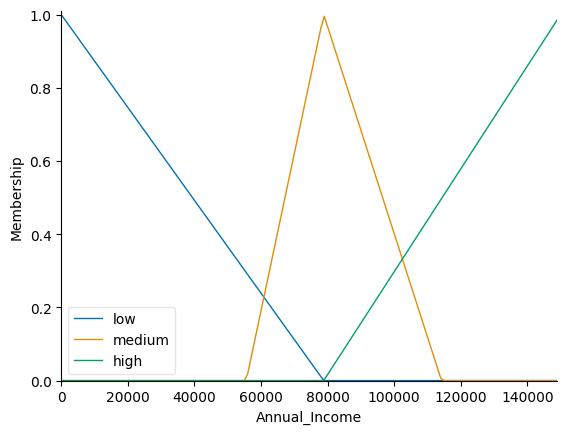

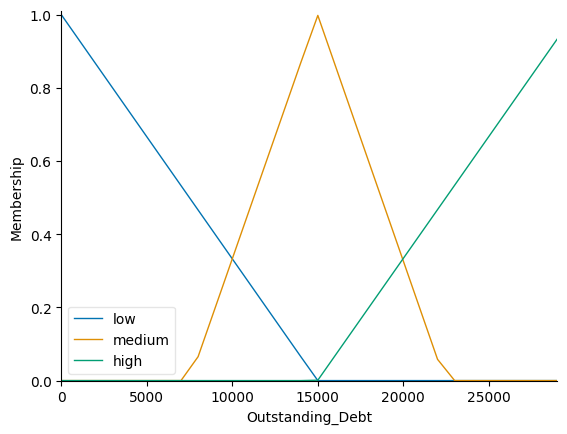

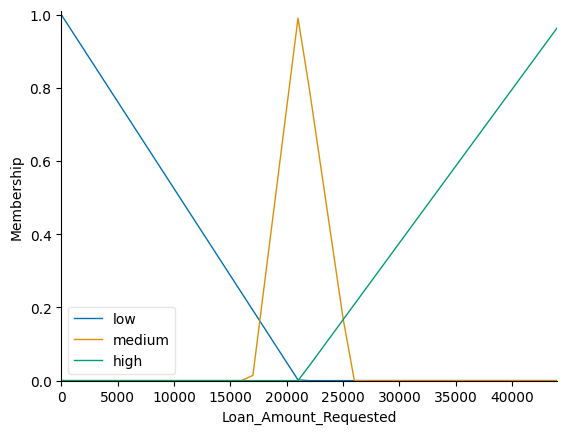

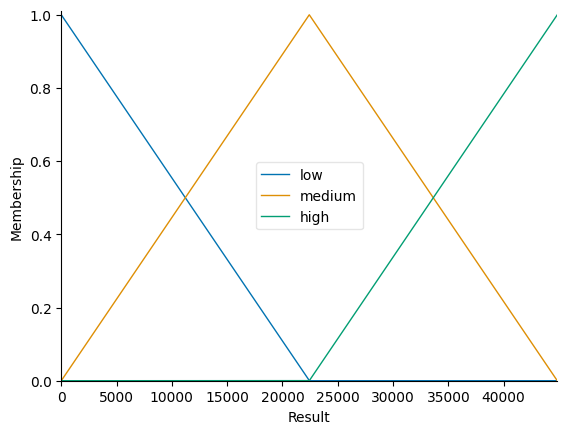

In [ ]:
# Calculating the max, min, and average of 'Annual_income' column
max_income = data['Annual_Income'].max()  
max_loan = data['Loan_Amount_Requested'].max()  
max_outstanding_debt = data['Outstanding_Debt'].max()

# Fuzy variable
annual_income = ctrl.Antecedent(np.arange(0, max_income + 1, 1000), 'Annual_Income')
loan_amount_requested = ctrl.Antecedent(np.arange(0, max_loan + 1, 1000), 'Loan_Amount_Requested')
outstanding_debt = ctrl.Antecedent(np.arange(0, max_outstanding_debt + 1, 1000), 'Outstanding_Debt')
result = ctrl.Consequent(np.arange(0, max_loan + 1, 1), 'Result') 


def custom_fuzzification(antecedent, data, column_name):
    """
    Sets up 'low', 'medium', and 'high' fuzzy membership functions for a given column in the data.
    
    Parameters:
    - antecedent: The fuzzy antecedent to apply the memberships to (e.g., annual_income).
    - data: The DataFrame containing the data.
    - column_name: The column name to base the membership functions on.
    """
    # Calculate cutoffs dynamically
    low_cutoff = data[column_name].quantile(0.5)
    medium_cutoff_start = data[column_name].quantile(0.25)
    medium_cutoff_middle = data[column_name].quantile(0.5)
    medium_cutoff_end = data[column_name].quantile(0.75)
    max_value = data[column_name].max()

    # Triangular membership functions
    antecedent['low'] = fuzz.trimf(antecedent.universe, [0, 0, low_cutoff])
    antecedent['medium'] = fuzz.trimf(antecedent.universe, [medium_cutoff_start, medium_cutoff_middle, medium_cutoff_end])
    antecedent['high'] = fuzz.trimf(antecedent.universe, [medium_cutoff_middle, max_value, max_value])

# Custom fuzzification function
custom_fuzzification(annual_income, data, "Annual_Income")
custom_fuzzification(loan_amount_requested, data, "Loan_Amount_Requested")
custom_fuzzification(outstanding_debt, data, "Outstanding_Debt")


# maybe average later or not
result['low'] = fuzz.trimf(result.universe, [0, 0, max_loan/2])
result['medium'] = fuzz.trimf(result.universe, [0, max_loan/2, max_loan])
result['high'] = fuzz.trimf(result.universe, [max_loan/2, max_loan, max_loan])


annual_income.view()
outstanding_debt.view()
loan_amount_requested.view()
result.view()

In [ ]:
# Split the training data into X_train, X_val, y_train, y_val
# # Split the data into 80% train and 20% 
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Display the shapes of the datasets
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (20919, 7), y shape: (20919,)


In [ ]:
# sizes = [X_train.shape[0], X_val.shape[0]]
# labels = ['X_train', 'X_val']

# # Create a bar plot to visualize the sizes of the datasets
# plt.figure(figsize=(8, 5))
# plt.bar(labels, sizes, color=['blue', 'orange'])

# # Add labels and title
# plt.xlabel('Dataset')
# plt.ylabel('Number of Samples')
# plt.title('Sizes of Train and Validation Datasets')

# # Display the plot
# plt.show()

In [ ]:
# Rule 1: Low income and low debt result in a low loan amount
rule1 = ctrl.Rule(annual_income['low'] & outstanding_debt['low'], result['low'])

# Rule 2: Medium income and low debt result in a medium loan amount
rule2 = ctrl.Rule(annual_income['medium'], result['medium'])

# Rule 3: High income and low debt result in a high loan amount
rule3 = ctrl.Rule(annual_income['high'] & outstanding_debt['low'], result['high'])


In [ ]:
# Fuzzy control system
loan_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
loan_decision = ctrl.ControlSystemSimulation(loan_ctrl)

In [ ]:
# predict loan approval/rejection
def predict_loan_decision(record_of_data):
    # Pass inputs to the fuzzy system
    annual_income_value = record_of_data['Annual_Income'] 
    outstanding_debt_value = record_of_data['Outstanding_Debt']

    # Compute the fuzzy
    loan_decision.compute()

    # Get loan amount
    loan_amount = loan_decision.output['Result']

    return loan_amount

In [ ]:
# For testing we use random single data

In [ ]:
record_of_data = data.sample(1)

In [ ]:
predicted_loan = predict_loan_decision(record_of_data)


ValueError: All antecedents must have input values!

In [ ]:
print(predicted_loan)

8494.891145532401


In [ ]:
# For testing we use random multi data

In [ ]:
data_sample = data.sample(10)

In [ ]:
predicted_loan_amounts = []
for index, record in data_sample.iterrows(): 
    loan_amount = predict_loan_decision(record)  # Assuming predict_loan_decision is already defined
    predicted_loan_amounts.append(loan_amount) 

In [ ]:
# Predict the sample data to get reslts 
predicted_loan_amounts = []
for index, record in data_sample.iterrows():  # Iterating over rows as Series
    loan_amount = predict_loan_decision(record)  # Pass the entire row (Series) to the function
    predicted_loan_amounts.append(loan_amount)

print(predicted_loan_amounts)


[np.float64(8494.891145532401), np.float64(8494.891145532401), np.float64(8494.891145532401), np.float64(8494.891145532401), np.float64(8494.891145532401), np.float64(8494.891145532401), np.float64(8494.891145532401), np.float64(8494.891145532401), np.float64(8494.891145532401), np.float64(8494.891145532401)]


In [ ]:
data_sample['Predicted_Loan_Amount'] = predicted_loan_amounts

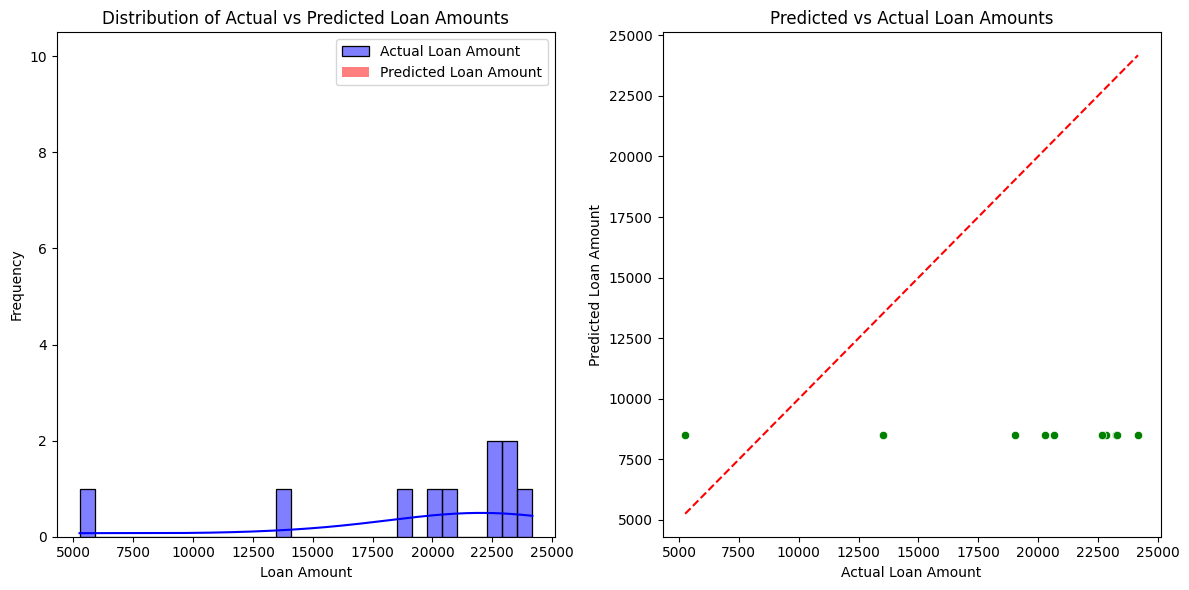

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Plotting Distribution of Actual vs Predicted Loan Amounts
plt.figure(figsize=(12, 6))

# Plot histogram of actual loan amounts vs predicted loan amounts
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
sns.histplot(data_sample['Loan_Amount_Requested'], color='blue', kde=True, label='Actual Loan Amount', bins=30)
sns.histplot(data_sample['Predicted_Loan_Amount'], color='red', kde=True, label='Predicted Loan Amount', bins=30)
plt.legend()
plt.title("Distribution of Actual vs Predicted Loan Amounts")
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")

# Plotting Predicted vs Actual Loan Amounts
plt.subplot(1, 2, 2)  
sns.scatterplot(x=data_sample['Loan_Amount_Requested'], y=data_sample['Predicted_Loan_Amount'], color='green')
plt.plot([data_sample['Loan_Amount_Requested'].min(), data_sample['Loan_Amount_Requested'].max()],
         [data_sample['Loan_Amount_Requested'].min(), data_sample['Loan_Amount_Requested'].max()],
         'r--')  # Plot a line of equality
plt.title("Predicted vs Actual Loan Amounts")
plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")

# Display the plots
plt.tight_layout()
plt.show()


## old code

In [ ]:
# Print the columns
# print(data.columns)

# Print dataset colums
# data.head(100)

# print(data.columns)

# # Define fuzzy variables (input variables)
# # We selected the most important columns from the dataset to use later in the rules.
# selected_columns = ['Employment_Status', 'Annual_Income', 'Credit_Score', 'Outstanding_Debt', 'Loan_Amount_Requested', 'Loan_Type','Loan_Purpose', 'Loan_Approval_Status']

# Employment_Status = ctrl.Antecedent(np.arange(18, 101, 1), 'Employment_Status')
# Annual_Income = ctrl.Antecedent(np.arange(0, 500000, 1000), 'Annual_Income')
# Credit_Score = ctrl.Antecedent(np.arange(1000, 50000, 500), 'Credit_Score')
# Outstanding_Debt = ctrl.Antecedent(np.arange(0, 30, 0.1), 'Outstanding_Debt')
# Loan_Amount_Requested = ctrl.Antecedent(np.arange(0, 1, 0.01), 'Loan_Amount_Requested')
# Loan_Type = ctrl.Consequent(np.arange(0, 2, 1), 'Loan_Type')

# # Loan_Purpose = ctrl.Antecedent(np.arange(0, 30, 0.1), 'Loan_Purpose') Do not need this, all are HOME
# Loan_Approval_Status = ctrl.Antecedent(np.arange(0, 1, 0.01), 'Loan_Approval_Status')